In [130]:
''' Imports '''
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import trapezoid 
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
import os

In [118]:
'''Parzen Kernel function'''
def parzen_kde(vals, x_vals, bandwidth):
    n = len(vals)
    densities = []

    for x in x_vals:
        count = np.sum(np.abs((vals - x) / bandwidth) <= 1)
        density = count / (n * bandwidth)
        densities.append(density)

    return np.array(densities)

In [119]:
'''Global var'''
TO_FEW = 5
LOWEST_VAR = 1e-5
DATA_SOURCE = '../data/source.csv'

In [120]:
'''Loading and displayng few records'''
source_file = pd.read_csv(DATA_SOURCE, index_col=0)
source_file.head()

,Serial,Source,X1,X2,X3,X4,X5,X6,X7,-01,...,ong,ong-,ria,rial,ser,seri,seria,tol,tolo,tolon
index,,,,,,,,,,,,,,,,,,,,,
0,MNOJUE-084279,isOK,6,6,6,0,13,6,0,0,...,0,0,0,0,0,0,0,0,0,0
1,JKLPDY12-13,isOK,6,4,4,0,11,6,0,0,...,0,0,0,0,0,0,0,0,0,0
2,WDS49kAUY,isNotOK,7,2,2,0,9,6,1,0,...,0,0,0,0,0,0,0,0,0,0
3,MNORSP-063772,isOK,6,6,6,0,13,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,MNOMPN-021264,isOK,6,6,6,0,13,6,0,0,...,0,0,0,0,0,0,0,0,0,0


In [121]:
''' Binary lable selecting only features columns'''

source_file["label"] = source_file["Source"].map({"isOK": 0, "isNotOK": 1})

feature_cols = source_file.select_dtypes(include=[np.number]).columns.drop(["index", "label"], errors='ignore')

In [122]:
'''Drop low var columns'''
low_var_cols = source_file[feature_cols].var() < LOWEST_VAR
feature_cols = feature_cols[~low_var_cols]

In [123]:
'''Dleta Resarch variation and delta overview'''
h_values = list(range(2, 20))
avg_deltas = []
avg_kde_variances = []

all_deltas = {h: [] for h in h_values}
all_kde_vars = {h: [] for h in h_values}

for feature in tqdm(feature_cols, desc="Delta i szum KDE dla różnych h"):

    ok_vals = source_file[source_file["label"] == 0][feature].dropna().values
    err_vals = source_file[source_file["label"] == 1][feature].dropna().values

    if len(ok_vals) < TO_FEW or len(err_vals) < TO_FEW:
        continue

    x_min = min(ok_vals.min(), err_vals.min())
    x_max = max(ok_vals.max(), err_vals.max())
    x_vals = np.linspace(x_min, x_max, 100)

    for h in h_values:
        kde_ok = parzen_kde(ok_vals, x_vals, h)
        kde_err = parzen_kde(err_vals, x_vals, h)

        diff_squared = (kde_ok - kde_err) ** 2
        delta_j = trapezoid(diff_squared, x_vals)

        # Wariancja KDE (połączenie dwóch klas, jako miara "rozrzutu")
        kde_combined = (kde_ok + kde_err) / 2
        kde_var = np.var(kde_combined)

        all_deltas[h].append(delta_j)
        all_kde_vars[h].append(kde_var)

# Obliczamy średnie wartości
for h in h_values:
    avg_deltas.append(np.mean(all_deltas[h]))
    avg_kde_variances.append(np.mean(all_kde_vars[h]))



Delta i szum KDE dla różnych h: 100%|██████████| 107/107 [00:07<00:00, 14.78it/s]


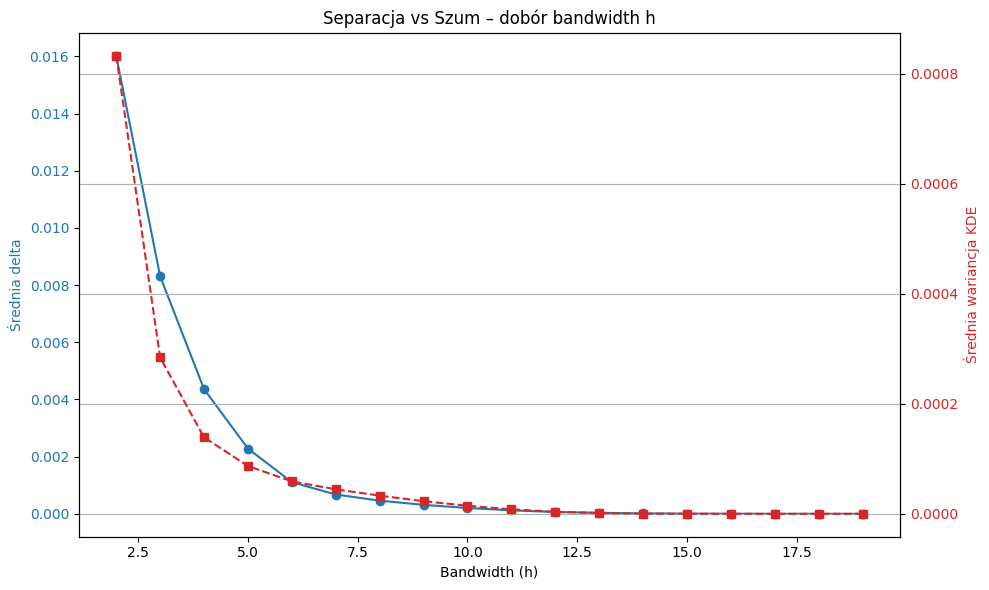

In [124]:
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
color2 = 'tab:red'

ax1.set_xlabel('Bandwidth (h)')
ax1.set_ylabel('Średnia delta', color=color1)
ax1.plot(h_values, avg_deltas, marker='o', color=color1, label='Średnia delta')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # Druga oś Y
ax2.set_ylabel('Średnia wariancja KDE', color=color2)
ax2.plot(h_values, avg_kde_variances, marker='s', linestyle='--', color=color2, label='Wariancja KDE')
ax2.tick_params(axis='y', labelcolor=color2)

plt.title('Separacja vs Szum – dobór bandwidth h')
fig.tight_layout()
plt.grid(True)
plt.show()


In [125]:
'''Delta Calculation'''
fixed_bandwidth = 10
delta_scores = {}

for feature in tqdm(feature_cols, desc="Finalna delta_j (h=10)"):

    ok_vals = source_file[source_file["label"] == 0][feature].dropna().values
    err_vals = source_file[source_file["label"] == 1][feature].dropna().values

    if len(ok_vals) < TO_FEW or len(err_vals) < TO_FEW:
        continue

    x_min = min(ok_vals.min(), err_vals.min())
    x_max = max(ok_vals.max(), err_vals.max())
    x_vals = np.linspace(x_min, x_max, 100)

    kde_ok = parzen_kde(ok_vals, x_vals, fixed_bandwidth)
    kde_err = parzen_kde(err_vals, x_vals, fixed_bandwidth)

    diff_squared = (kde_ok - kde_err) ** 2
    delta_j = trapezoid(diff_squared, x_vals)

    delta_scores[feature] = delta_j

Finalna delta_j (h=10): 100%|██████████| 107/107 [00:00<00:00, 138.71it/s]


In [126]:
'''Select By Delta'''
top_n = 10000000
selected_features = sorted(delta_scores.items(), key=lambda x: -x[1])[:top_n]
selected_features = [f[0] for f in selected_features]

X = source_file[selected_features].dropna().astype(int)

In [127]:
'''Distans Rajski matrix'''
distance_matrix = pd.DataFrame(
    squareform(pdist(X.T, metric='jaccard')),
    index=selected_features,
    columns=selected_features
)

In [128]:
'''20 best features'''
alpha = 0.7
selected = []
candidates = list(selected_features)
delta_top = {f: delta_scores[f] for f in selected_features}

start = max(delta_top, key=delta_top.get) 
selected.append(start)
candidates.remove(start)

while len(selected) < 20:
    best_score = -1
    best_feature = None

    for f in candidates:
        min_dist = min([distance_matrix.loc[f, s] for s in selected])
        combined_score = alpha * delta_top[f] + (1 - alpha) * min_dist # k score best features

        if combined_score > best_score:
            best_score = combined_score
            best_feature = f

    selected.append(best_feature)
    candidates.remove(best_feature)

print("Wybrane cechy:", selected)


Wybrane cechy: ['X1', 'X4', '12-', '05-', '11-', '01-', '07-', '09-', '06-', '03-', '10-', '02-', '04-', '3ax', 'def4', 'def2', 'def8', 'def7', 'def1', 'def9']


In [ ]:
'''trening test val '''
final_df = source_file[selected + ['label']].dropna()

train_df, temp_df = train_test_split(final_df, test_size=0.30, random_state=42, stratify=final_df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

os.makedirs("../data/NN", exist_ok=True)
train_df.to_csv("../data/NN/train.csv", index=False)
val_df.to_csv("../data/NN/val.csv", index=False)
test_df.to_csv("../data/NN/test.csv", index=False)

print("Dane gotowe i zapisane do data/NN/")
print(f"Rekordy: train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")

✅ Dane gotowe i zapisane do data/NN/
Rekordy: train=14000, val=3000, test=3000
